In [49]:
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume,RSI,RSI_Strategy,BB_SMA,BB_STD,Upper_Band,Lower_Band,BB_Strategy,Full_Strategy,Strategy,Asset_Returns,Strategy_Returns
32,158.710007,174.654999,158.220001,174.449997,279700,69.446316,-1.0,140.249000,17.839278,158.088278,122.409722,NaN,NaN,0,NaN,NaN
33,160.089996,166.460007,159.000000,159.000000,310400,68.827901,0.0,141.503500,18.326275,159.829775,123.177224,-1.0,-1.0,0,0.008695,0.000000
34,160.289993,164.160004,158.600006,161.330002,303700,68.838591,0.0,142.843999,18.685502,161.529502,124.158497,-1.0,-1.0,0,0.009955,0.000000
35,185.000000,185.850006,158.000000,158.570007,437400,80.993710,0.0,145.518999,20.697243,166.216242,124.821757,0.0,0.0,0,0.165648,0.000000
36,184.979996,191.500000,183.050003,185.199997,697700,80.960108,-1.0,148.459999,21.943170,170.403169,126.516829,-1.0,-2.0,-3,0.165522,0.000324
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
955,529.049988,536.000000,522.260010,525.000000,698200,91.315012,-1.0,448.536502,75.448573,523.985075,373.087929,-1.0,-2.0,-3,2.333438,-0.808481
956,520.229980,531.018982,515.200012,517.789978,733300,86.880310,-1.0,458.744501,70.212375,528.956876,388.532126,-1.0,-2.0,-3,2.277865,-0.798902
957,525.729980,526.919983,514.039978,517.580017,764200,86.962169,-1.0,468.214000,65.444447,533.658447,402.769553,0.0,-1.0,0,2.312519,-0.798902
958,514.299988,531.940002,510.720001,522.770020,840800,80.855191,-1.0,475.428999,61.905421,537.334420,413.523578,0.0,-1.0,0,2.240501,-0.798902


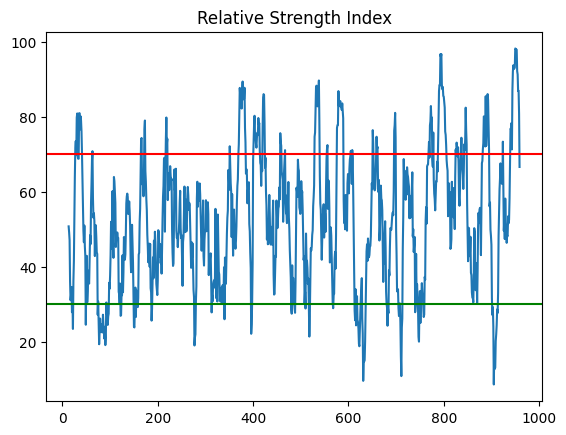

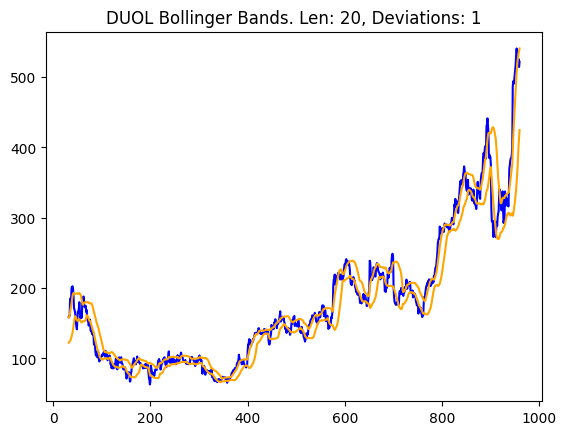

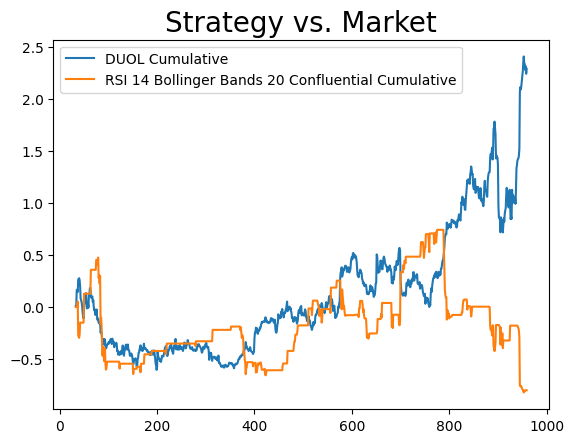

In [50]:
TICKER = 'DUOL'
INTERVAL='1d'

# set period based on interval
if INTERVAL == '1h':
    PERIOD = '730d'
else:
    PERIOD = 'max'

BB_LEN = 20
DEVS = 1
RSI_LENGTH = 14
RSI_OVERBOUGHT = 70
RSI_OVERSOLD = 30

# what subsetion of that data are you interested in
LOOKBACK = 10000

def get_data(ticker=TICKER, lookback=LOOKBACK, interval=INTERVAL):

    # get data at interval you want
    df = yf.download(ticker, interval=interval, period=PERIOD)
    df.columns = df.columns.get_level_values(0)

    # reset the index to make plots prettier
    df = df.reset_index(drop=True)

    # only return the subset of data you are interested in
    return df.iloc[-lookback:, :]

def add_RSI(df, length=RSI_LENGTH, overbought=RSI_OVERBOUGHT, oversold=RSI_OVERSOLD):

    price_change = df['Close'].diff()
    
    # separate gains/losses
    gain = price_change.where(price_change > 0, 0)
    loss = -price_change.where(price_change < 0, 0)

    # average gain vs loss
    avg_gain = gain.rolling(window=length).mean()
    avg_loss = loss.rolling(window=length).mean()

    # calculate rsi
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    df['RSI'] = rsi

    # plot the relative strength index
    plt.plot(df['RSI'])
    plt.axhline(overbought, color='red')
    plt.axhline(oversold, color='green')
    plt.title('Relative Strength Index')

    return df.dropna()

def add_RSI_strategy(df, overbought=RSI_OVERBOUGHT, oversold=RSI_OVERSOLD):

    df['RSI_Strategy'] = 0
    df['RSI_Strategy'] = np.where(df['RSI'] > overbought, -1, 
                     np.where(df['RSI'] < oversold, 1, 0))
    
    # shift back to make sure we have seen the signal
    df['RSI_Strategy'] = df['RSI_Strategy'].shift(1)
    return df

def add_BB(df, devs=DEVS, bb_len=BB_LEN):

    # can change to ema (use MACD video/code for reference)
    df['BB_SMA'] = df['Close'].rolling(bb_len).mean()

    # get the standard deviation of the close prices for the period
    df['BB_STD'] = df['Close'].rolling(bb_len).std()

    df['Upper_Band'] = df['BB_SMA'] + (devs * df['BB_STD'])
    df['Lower_Band'] = df['BB_SMA'] - (devs * df['BB_STD'])

    df = df.dropna()

    plt.figure()
    plt.plot(df['Close'], color='blue')
    plt.plot(df['Upper_Band'], color='orange')
    plt.plot(df['Lower_Band'], color='orange')

    plt.title(f'{TICKER} Bollinger Bands. Len: {BB_LEN}, Deviations: {DEVS}');

    return df

def add_BB_strategy(df):
    df['BB_Strategy'] = 0
    df['BB_Strategy'] = np.where(
        df['Close'] > df['Upper_Band'], -1, 
        np.where(df['Close'] < df['Lower_Band'], 1, 0)
        )
    
    df['BB_Strategy'] = df['BB_Strategy'].shift(1)
    
    return df

def add_full_strategy(df):

    df['Full_Strategy'] = df['RSI_Strategy'] + df['BB_Strategy']

    # adjust values for simplicity
    df['Strategy'] = np.where(df['Full_Strategy'] == 2, 3, 
                     np.where(df['Full_Strategy'] == -2, -3, 0))

    return df

def test_strategy(df):

    df['Asset_Returns'] = (1 + df['Close'].pct_change()).cumprod() - 1
    df['Strategy_Returns'] = (1 + df['Close'].pct_change() * df['Strategy']).cumprod() -1

    plt.figure()
    plt.plot(df['Asset_Returns'])
    plt.plot(df['Strategy_Returns'])
    plt.legend([f'{TICKER} Cumulative', f'RSI {RSI_LENGTH} Bollinger Bands {BB_LEN} Confluential Cumulative'])
    plt.title('Strategy vs. Market', size='20')

    return df

def main():
    df = get_data()
    df = add_RSI(df)
    df = add_RSI_strategy(df)
    df = add_BB(df)
    df = add_BB_strategy(df)
    df = add_full_strategy(df)
    df = test_strategy(df)

    return df

df = main()

df